### CyberSecurity ground truth prediction

In the evolving cybersecurity landscape, the increase in threat actors has overwhelmed enterprise security operation centers (SOCs) with incidents. This situation necessitates solutions for classifying the threat and triggering a remediation process. However, fully automated systems require a very high confidence threshold to avoid errors due to automated actions, making them often impractical. As a result, guided response (GR) systems have been developed to aid SOC analysts in making informed decisions. These guided response systems require a triaged threat assessment that is then prioritized fed into an XDR (extended detection and response system) for review and action by a SOC analyst.

### Objective


The primary objective of the exercise is to accurately predict incident triage grades as true positive (TP), benign positive (BP), and false positive (FP)—based on labeled responses from SOCs of customers. 

Considering that businesses that rely on 24x7 connectivity, a business impact due to mis handling of alerts/incidents (either ignored, or bring down services in response to ones that did not need it) could be huge. As such high precision and a high recall is desired on the predicted for TruePositive and False Positive classifications

### Data

The data set comprises of 13 million pieces of evidence across 33 entity types, covering 1.6 million alerts and 1 million annotated incidents with triage labels from customers over a two-week period. The dataset is built from telemetry from 6100 organizations, using 9100 unique detectors. All data has been anonymized. More information on how this data was prepared, how alerts were corelated into incidents can be found in this whitepaper: https://arxiv.org/abs/2407.09017. The scope of this initiative was much larger - to corelate events, triage prediction and remediation action prediction. This focus of this analysis is triage prediction only.

The data is available on Kaggle 

https://www.kaggle.com/datasets/Microsoft/microsoft-security-incident-prediction

For the purposes of my analysis (due to compute restrictions, i have limited the data to 100K records)

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_curve, f1_score, confusion_matrix, classification_report, auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC
from imblearn.metrics import specificity_score

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# helper library for drawing plots
from plot_helpers import render_plot

pd.set_option('display.max_columns', None)

In [71]:

dtype_spec = {                                  # added to avoid a data load warning about objectives types for these features
    'ActionGrouped': 'object',
    'ActionGranular': 'object'
}


# Read the sampled train and test records (pls see split_data_files.ipynb)
df_train_original = pd.read_csv('DATA/GUIDE_Train.csv', dtype=dtype_spec, compression='zip')
df_test_original = pd.read_csv('DATA/GUIDE_Test.csv', dtype=dtype_spec, compression='zip')

In [72]:
# Check for imbalance in the distribution of target features
df_train_original.IncidentGrade.value_counts(normalize=True) * 100, df_test_original.IncidentGrade.value_counts(normalize=True) * 100

(IncidentGrade
 BenignPositive    43.333561
 TruePositive      35.145158
 FalsePositive     21.521281
 Name: proportion, dtype: float64,
 IncidentGrade
 BenignPositive    42.2350
 TruePositive      36.1058
 FalsePositive     21.6592
 Name: proportion, dtype: float64)

In [73]:
nsamples = 50000

# Retrieve and concatenate 30000 records for each of the target classes in IncidentGrade to balance the classes
df_train = pd.concat([df_train_original[df_train_original.IncidentGrade == 'BenignPositive'].sample(n=nsamples, random_state=42),
                               df_train_original[df_train_original.IncidentGrade == 'TruePositive'].sample(n=nsamples, random_state=42),
                               df_train_original[df_train_original.IncidentGrade == 'FalsePositive'].sample(n=nsamples, random_state=42)])

df_test = pd.concat([df_test_original[df_test_original.IncidentGrade == 'BenignPositive'].sample(n=nsamples, random_state=42),
                               df_test_original[df_test_original.IncidentGrade == 'TruePositive'].sample(n=nsamples, random_state=42),
                               df_test_original[df_test_original.IncidentGrade == 'FalsePositive'].sample(n=nsamples, random_state=42)])


In [5]:
# verify the distribution of the target feature in the final data set
df_train.IncidentGrade.value_counts(normalize=True) * 100, df_test.IncidentGrade.value_counts(normalize=True) * 100

(IncidentGrade
 BenignPositive    33.333333
 TruePositive      33.333333
 FalsePositive     33.333333
 Name: proportion, dtype: float64,
 IncidentGrade
 BenignPositive    33.333333
 TruePositive      33.333333
 FalsePositive     33.333333
 Name: proportion, dtype: float64)

In [74]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 150000 entries, 196087 to 450534
Data columns (total 45 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Id                  150000 non-null  int64  
 1   OrgId               150000 non-null  int64  
 2   IncidentId          150000 non-null  int64  
 3   AlertId             150000 non-null  int64  
 4   Timestamp           150000 non-null  object 
 5   DetectorId          150000 non-null  int64  
 6   AlertTitle          150000 non-null  int64  
 7   Category            150000 non-null  object 
 8   MitreTechniques     66448 non-null   object 
 9   IncidentGrade       150000 non-null  object 
 10  ActionGrouped       82 non-null      object 
 11  ActionGranular      82 non-null      object 
 12  EntityType          150000 non-null  object 
 13  EvidenceRole        150000 non-null  object 
 14  DeviceId            150000 non-null  int64  
 15  Sha256              150000 non-nul

In [75]:
df_train.sample(3)

,Id,OrgId,IncidentId,AlertId,Timestamp,DetectorId,AlertTitle,Category,MitreTechniques,IncidentGrade,ActionGrouped,ActionGranular,EntityType,EvidenceRole,DeviceId,Sha256,IpAddress,Url,AccountSid,AccountUpn,AccountObjectId,AccountName,DeviceName,NetworkMessageId,EmailClusterId,RegistryKey,RegistryValueName,RegistryValueData,ApplicationId,ApplicationName,OAuthApplicationId,ThreatFamily,FileName,FolderPath,ResourceIdName,ResourceType,Roles,OSFamily,OSVersion,AntispamDirection,SuspicionLevel,LastVerdict,CountryCode,State,City
6268,1125281433373,0,80,318406,2024-06-05T17:42:07.000Z,7,6,InitialAccess,NaN,TruePositive,NaN,NaN,User,Impacted,98799,138268,360606,160396,5669,8140,5712,6138,153085,529644,NaN,1631,635,860,2251,3421,881,NaN,289573,117668,3586,NaN,NaN,5,66,NaN,NaN,NaN,242,1445,10630
308242,1288490192564,3,193644,765295,2024-06-13T19:03:27.000Z,2,2,CommandAndControl,NaN,BenignPositive,NaN,NaN,Url,Related,98799,138268,360606,151,441377,673934,425863,453297,153085,529644,NaN,1631,635,860,2251,3421,881,NaN,289573,117668,3586,NaN,NaN,5,66,NaN,Suspicious,Suspicious,242,1445,10630
259365,1451698946839,61,201811,549886,2024-06-03T03:59:10.000Z,5,31,SuspiciousActivity,NaN,FalsePositive,NaN,NaN,CloudApplication,Impacted,98799,138268,360606,160396,441377,673934,425863,453297,153085,529644,NaN,1631,635,860,0,0,881,NaN,289573,117668,3586,NaN,NaN,5,66,NaN,NaN,NaN,242,1445,10630


### Incident/Alert schema
https://learn.microsoft.com/en-us/defender-xdr/advanced-hunting-alertevidence-table

Not all columns in the source schema have been included in the data set provided to us

#### Data description:
- OrgId: ID of the organization from which the data was collected
- IncidentId: ID assigned to the incident. An incident co-relates a set of events
- AlertId: ID assigned to a given alert
- Timestamp: Date and time when the event was recorded
- DetectorID: Detection technology or sensor that identified the notable component or activity
- AlertTitle: Title of the alert
- Category: List of categories that the information belongs to (in this data set, each record only contains one category)
- MitreTechniques: MITRE ATT&CK techniques https://attack.mitre.org/
- IncidentGrade: Labeled data that indicates whether the alert or incident was BP, TP or FP
- ActionGrouped, Action Granular: These correspond to further actions recommended for action by a SOC analyst. These are outside the scope of this project.
- EntityType: Type of object, such as a file, a process, a device, or a user
- EvidenceRole: How the entity is involved in an alert, indicating whether it is impacted or is merely related
- DeviceId: Unique identifier for the device in the service
- Sha256: Hash of the file that the recorded action was applied to
- IpAddress: IP address assigned to the local device used during communication
- Url: URL or fully qualified domain name (FQDN) that was being connected to
- AccountSid: Security Identifier (SID) of the account
- AccountUpn: User principal name (UPN) of the account
- AccountObjectId: Unique identifier for the account
- AccountName: User name of the account
- DeviceName: FQDN of the device
- NetworkMessageId: Unique identifier for the email
- EmailClusterId: ClusterId of ther email server
- RegistryKey: Registry key that the recorded action was applied to
- RegistryValueName: Name of the registry value that the recorded action was applied to
- RegistryValueData: Data of the registry value that the recorded action was applied to
- ApplicationId: Unique identifier for the application
- ApplicationName: Application that performed the recorded action
- OAuthApplicationId: Unique identifier of the third-party OAuth application
- ThreatFamily: Malware family that the suspicious or malicious file or process has been classified under
- FileName: Name of the file that the recorded action was applied to
- FolderPath: Folder containing the file that the recorded action was applied to
- ResourceIdName: Unique identifier of the cloud resource accessed
- ResourceType: Type of cloud resource
- Roles: 
- OSFamily: 
- OSVersion:
- AntispamDirection: 
- SuspicionLevel: 
- LastVerdict: 
- CountryCode
- State
- City




### EDA

In [8]:
df_train.shape, df_test.shape

((150000, 45), (150000, 46))

In [9]:
# The test set has one more column than the train set. find the column that is different between the two data sets
set(df_train.columns).symmetric_difference(set(df_test.columns))

{'Usage'}

In [10]:
# explore the value within the Usage column in the test data set
df_test.Usage.value_counts()

Usage
Public     106212
Private     43788
Name: count, dtype: int64

In [11]:
# This importance of this field has to be verified with a SME. Current interpretation is this column appears 
# to indicate how the test data should be used. Since the column is not present in the training data, I will be 
# removed from the test data
# 
df_test.drop(columns=['Usage'], inplace=True)

In [12]:
df_test.sample()

,Id,OrgId,IncidentId,AlertId,Timestamp,DetectorId,AlertTitle,Category,MitreTechniques,IncidentGrade,ActionGrouped,ActionGranular,EntityType,EvidenceRole,DeviceId,Sha256,IpAddress,Url,AccountSid,AccountUpn,AccountObjectId,AccountName,DeviceName,NetworkMessageId,EmailClusterId,RegistryKey,RegistryValueName,RegistryValueData,ApplicationId,ApplicationName,OAuthApplicationId,ThreatFamily,FileName,FolderPath,ResourceIdName,ResourceType,Roles,OSFamily,OSVersion,AntispamDirection,SuspicionLevel,LastVerdict,CountryCode,State,City
105835,85899349847,20,1784,1550,2024-05-30T09:41:06.000Z,79,1378,Impact,NaN,FalsePositive,NaN,NaN,Ip,Related,98799,138268,2844,160396,441377,673934,425863,453297,153085,529644,NaN,1631,635,860,2251,3421,881,NaN,289573,117668,3586,NaN,NaN,5,66,NaN,NaN,NaN,242,1445,10630


In [13]:
# check for missing values in target variable in both data sets
df_train.IncidentGrade.isna().sum(), df_test.IncidentGrade.isna().sum()

(0, 0)

In [14]:
# drop the rows with missing values in the target variable
df_train.dropna(subset=['IncidentGrade'], inplace=True)

In [15]:
#### Columns  needed for this analyis
# This data set has labels for two different needs: initial triage of incidents/alerts (IncidentGrade), and proposed remediation actions (ActionGrandular). 
# This objective of my analysis is only to predict an initial triage for the alerts and incidents i.e. ground truth - true positive, benign positive and false positive.
# As such i will ignore the columns related to proposed remedation actions (Last Verdict, ActionGrouped, Action Granualar, LastVerdict, SuspicionLevel)

cat_columns = ['Category', 'EntityType', 'EvidenceRole', 'SuspicionLevel', 'LastVerdict',
               'ResourceType', 'Roles', 'AntispamDirection', 'ThreatFamily']

numerical_columns = ['DeviceId', 'Sha256', 'IpAddress', 'Url', 'AccountSid', 'AccountUpn', 'AccountObjectId',
                     'AccountName', 'DeviceName', 'NetworkMessageId', 'EmailClusterId', 'RegistryKey',
                     'RegistryValueName', 'RegistryValueData', 'ApplicationId', 'ApplicationName',
                     'OAuthApplicationId', 'FileName', 'FolderPath', 'ResourceIdName', 'OSFamily', 
                     'OSVersion', 'CountryCode', 'State', 'City']

# create a list to drop additional columns that may not be needed after EDA
drop_columns = []



In [16]:
# convert timestamp to datetime
df_train['Timestamp'] = pd.to_datetime(df_train['Timestamp'])
df_test['Timestamp'] = pd.to_datetime(df_test['Timestamp'])

# this may be useful for forecasting (not in current scope of this project, but may add later)

In [17]:
# Find null values in the dataset
null_values = df_train.isnull().sum()
print(null_values.sort_values(ascending=False))

ResourceType          149919
ActionGrouped         149918
ActionGranular        149918
ThreatFamily          148847
EmailClusterId        148585
AntispamDirection     147337
Roles                 146260
SuspicionLevel        128753
LastVerdict           116907
MitreTechniques        83552
FileName                   0
RegistryValueName          0
RegistryValueData          0
ApplicationId              0
ApplicationName            0
OAuthApplicationId         0
Id                         0
FolderPath                 0
ResourceIdName             0
OSFamily                   0
OSVersion                  0
CountryCode                0
State                      0
RegistryKey                0
DeviceName                 0
NetworkMessageId           0
OrgId                      0
IncidentId                 0
AlertId                    0
Timestamp                  0
DetectorId                 0
AlertTitle                 0
Category                   0
IncidentGrade              0
EntityType    

In [18]:
# Mark columns with more than 90% missing values for removal
drop_columns.extend(['ResourceType', 'ActionGrouped', 'ActionGranular', 'ThreatFamily', 'EmailClusterId', 'Roles', 'AntispamDirection'])
drop_columns

['ResourceType',
 'ActionGrouped',
 'ActionGranular',
 'ThreatFamily',
 'EmailClusterId',
 'Roles',
 'AntispamDirection']

#### Categorical features

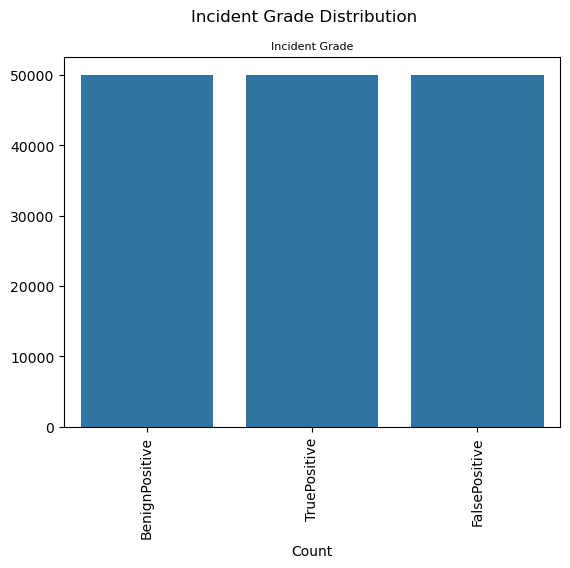

In [19]:
# Explore IncidentGrade
ax = sns.countplot(x='IncidentGrade', data=df_train)
render_plot(ax, 'Incident Grade Distribution', 'Incident Grade', 'Count', plotname='IncidentGradeDistribution', displaybarlabel=False) 

All 3 classes are same, this is the result of picking up stratified samples from the original data

In [20]:
# Explore MitreTechniques
df_train.MitreTechniques.value_counts()

# More information on the Mitre Att$ck framework is here https://attack.mitre.org/

MitreTechniques
T1078;T1078.004                                    23318
T1566.002                                          12394
T1566                                              10420
T1133                                               3291
T1566.001                                           1900
                                                   ...  
T1021.002;T1027.002;T1027.005;T1047;T1105;T1570        1
T1027;T1027.002;T1027.005;T1105;T1204.002;T1560        1
T1590;T1046                                            1
T1053.002;T1059.001                                    1
T1059.001;T1069.001                                    1
Name: count, Length: 565, dtype: int64

For the purposes of this analysis, we will pick up the higher level Mitre techniques - for ex T1078, and not the sub techniques like T1078.004
A new column will be added in the FeatureEngineering section. If MitreTechnique is indeed found to be an importance feature we can further analyze the sub mitre techniques

In [21]:
# Find all incidents with duplicate AlertIds
duplicate_alerts = df_train[df_train.duplicated('AlertId', keep=False)]

# Show a few sample incidents that are marked true positive
duplicate_alerts[duplicate_alerts['IncidentGrade'] == 'TruePositive'].head(5)

,Id,OrgId,IncidentId,AlertId,Timestamp,DetectorId,AlertTitle,Category,MitreTechniques,IncidentGrade,ActionGrouped,ActionGranular,EntityType,EvidenceRole,DeviceId,Sha256,IpAddress,Url,AccountSid,AccountUpn,AccountObjectId,AccountName,DeviceName,NetworkMessageId,EmailClusterId,RegistryKey,RegistryValueName,RegistryValueData,ApplicationId,ApplicationName,OAuthApplicationId,ThreatFamily,FileName,FolderPath,ResourceIdName,ResourceType,Roles,OSFamily,OSVersion,AntispamDirection,SuspicionLevel,LastVerdict,CountryCode,State,City
298473,1288490192878,10,240,178,2024-05-23 01:38:52+00:00,12,52,Impact,NaN,TruePositive,NaN,NaN,Ip,Related,98799,138268,1844,160396,441377,673934,425863,453297,153085,529644,NaN,1631,635,860,2251,3421,881,NaN,289573,117668,3586,NaN,NaN,5,66,NaN,NaN,NaN,242,1445,10630
370982,1348619735496,230,4662,1667,2024-06-10 19:26:34+00:00,1,1,InitialAccess,T1566.002,TruePositive,NaN,NaN,User,Impacted,98799,138268,360606,160396,51941,55610,55326,55751,153085,529644,NaN,1631,635,860,2251,3421,881,NaN,289573,117668,3586,NaN,NaN,5,66,NaN,NaN,NaN,242,1445,10630
181151,876173330895,5,175961,162152,2024-06-05 21:03:40+00:00,4,3,InitialAccess,NaN,TruePositive,NaN,NaN,Ip,Related,98799,138268,46739,160396,441377,673934,425863,453297,153085,529644,NaN,1631,635,860,2251,3421,881,NaN,289573,117668,3586,NaN,NaN,5,66,NaN,NaN,NaN,33,1445,10630
319201,343597386303,28,19763,5061,2024-06-05 08:27:22+00:00,1,1,InitialAccess,T1566.002,TruePositive,NaN,NaN,User,Impacted,98799,138268,360606,160396,51649,56157,55990,56460,153085,529644,NaN,1631,635,860,2251,3421,881,NaN,289573,117668,3586,NaN,NaN,5,66,NaN,NaN,NaN,242,1445,10630
497434,180388630468,10,49,142,2024-05-24 09:22:33+00:00,12,392,Impact,NaN,TruePositive,NaN,NaN,Ip,Related,98799,138268,14488,160396,441377,673934,425863,453297,153085,529644,NaN,1631,635,860,2251,3421,881,NaN,289573,117668,3586,NaN,NaN,5,66,NaN,NaN,NaN,242,1445,10630


In [22]:
print(f'{duplicate_alerts.shape[0]} incidents have multiple alerts')

df_train[df_train.IncidentId == 173].shape[0]

47877 incidents have multiple alerts


157

The data set contains multiple Alerts, that are correlated to an Incident. For example IncidentId 173, contains 47 different Alerts. This corelation was already done by the XDR system from which this data is derived. As such for the purposes of this analysis we will try to predict triage grade at the row level, which symbolizes a unique alert (duplicates have been removed)

In [23]:
# Top 10 categories of alerts
df_train['Category'].value_counts(normalize=True).sort_values(ascending=False).head(10)*100

Category
InitialAccess         46.814000
Exfiltration          15.807333
SuspiciousActivity     9.850000
CommandAndControl      8.282000
Impact                 7.997333
CredentialAccess       3.259333
Execution              3.034000
Malware                1.402000
Discovery              1.367333
Persistence            0.707333
Name: proportion, dtype: float64

Top categories for Alerts are InitialAccess, Exfiltration, SuspiciousActivity, CommandAndControl

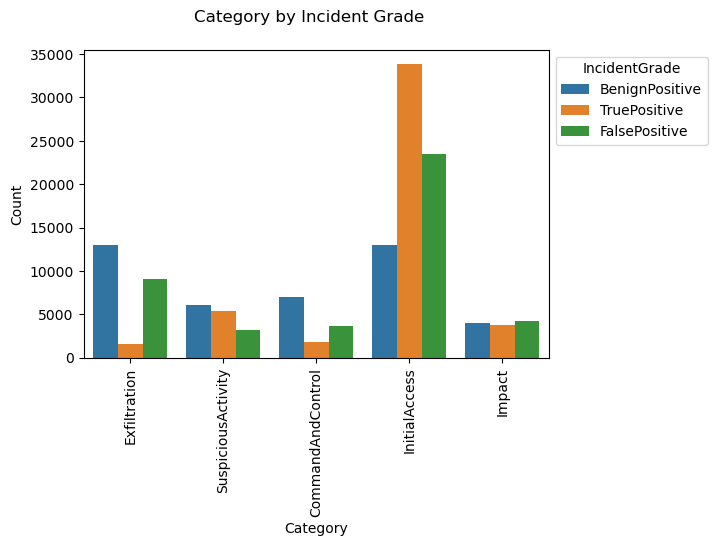

In [24]:
# plot top 5 categories with incident grade

top_10_categories = df_train['Category'].value_counts().head(5).index

plt.figure(figsize=(6, 4))
ax = sns.countplot(data=df_train[df_train['Category'].isin(top_10_categories)], x='Category', hue='IncidentGrade')
render_plot(ax, heading='Category by Incident Grade', xlabel='Category', ylabel='Count', plotname='CategoryByIncidentGrade.png', 
            displaybarlabel=False)


Exfiltration attemps appear to be last harmful compared to alerts marked as Initial Access, Suspicious or Impact

In [25]:
# explore the values within LastVerdict
# https://learn.microsoft.com/en-us/defender-xdr/m365d-remediation-actions

print(df_train['LastVerdict'].value_counts())


LastVerdict
Suspicious                                            20600
Malicious                                              6457
NoThreatsFound                                         6035
DomainPII_50d8b4a941c26b89482c94ab324b5a274f9ced66        1
Name: count, dtype: int64


In [26]:
# remove LastVerdict values that begin with 'Domain'
df_last_verdict = df_train[~df_train['LastVerdict'].str.startswith('Domain', na=False)]

In [27]:
# Summarize LastVerdict
print('Number of missing values in Last Verdict are: ', df_last_verdict['LastVerdict'].isna().sum()  )

Number of missing values in Last Verdict are:  116907


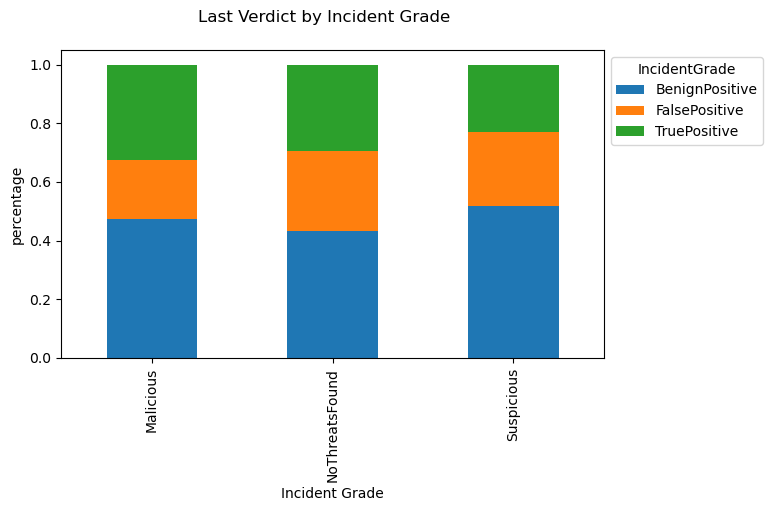

In [28]:
ax = df_last_verdict.groupby('LastVerdict')['IncidentGrade'].value_counts(normalize=True).unstack().plot(kind='bar', stacked=True, figsize=(7, 4))

render_plot(ax, heading='Last Verdict by Incident Grade', xlabel='Incident Grade', ylabel='percentage', 
            plotname='LastVerdictByIncidentGrade.png', displaybarlabel=False)



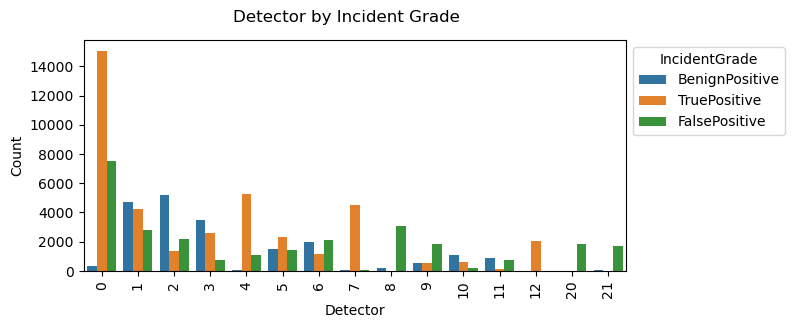

In [29]:
# plot top 10 Detectors by Incident Grade
top_10_detectors = df_train['DetectorId'].value_counts().head(15).index

plt.figure(figsize=(7, 3))
ax = sns.countplot(data=df_train[df_train['DetectorId'].isin(top_10_detectors)], x='DetectorId', hue='IncidentGrade')
render_plot(ax, heading='Detector by Incident Grade', xlabel='Detector', ylabel='Count', 
            plotname='DetectorByIncidentGrade.png', displaybarlabel=False)

In [30]:
# "DetectorId 0" typically refers to a generic or default detection mechanism, meaning it signifies an alert triggered by a broad security
# rule that isn't specifically tied to a particular security feature or detection method within the XDR platform; it usually indicates a 
# high-level threat that needs further investigation to pinpoint the exact source of the suspicious activity

# check the entity type for DetectorId = 0
df_train[df_train['DetectorId'] == 0]['EntityType'].value_counts()

EntityType
User                 6503
Ip                   6442
CloudLogonRequest    6363
CloudLogonSession    3607
Name: count, dtype: int64

### EntityTypes
https://learn.microsoft.com/en-us/azure/sentinel/entities-reference

In [31]:
# Unique values in EntityType
df_train['EntityType'].value_counts().head(10)

EntityType
Ip                   35407
User                 29887
MailMessage          18044
Machine              11536
CloudLogonRequest    10538
File                 10376
Url                  10264
Mailbox               7454
Process               4986
CloudLogonSession     3947
Name: count, dtype: int64

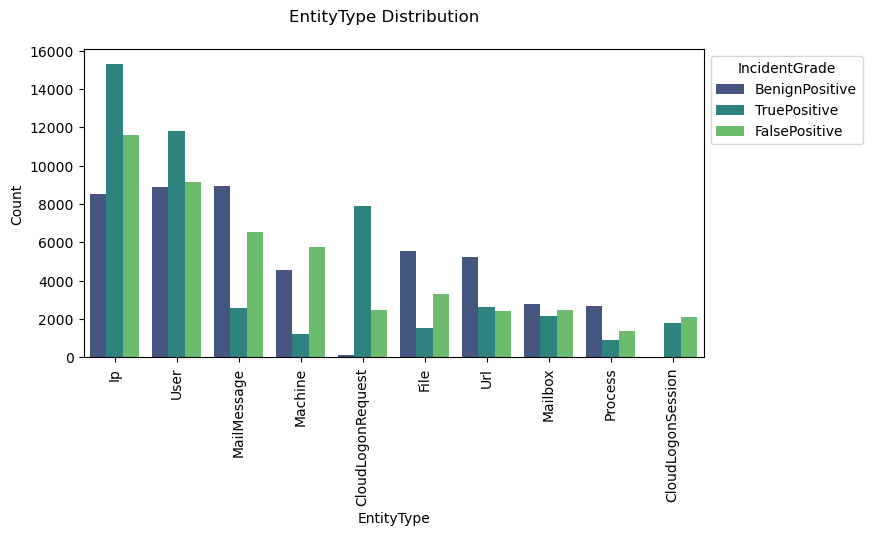

In [32]:
# check the distribution of EntityTypes
plt.figure(figsize=(8, 4))
ax = sns.countplot(data=df_train, x='EntityType', hue='IncidentGrade', order=df_train['EntityType'].value_counts().head(10).index, palette='viridis')
render_plot(ax, heading='EntityType Distribution', xlabel='EntityType', ylabel='Count', displaybarlabel=False, plotname='EntityTypeDistribution.png')


Most alerts are associated with Ip address entity type

In [33]:
#"evidencerole" refers to the specific part a particular piece of evidence plays within a security alert, indicating whether 
# it is the primary target of the attack, a related component, or simply provides supporting context for the incident; 
# essentially, it describes how the evidence is involved in the overall threat scenario

df_train.groupby(['IncidentGrade', 'EvidenceRole']).size().sort_values(ascending=False)  

IncidentGrade   EvidenceRole
TruePositive    Related         32819
FalsePositive   Related         26373
BenignPositive  Impacted        26005
                Related         23995
FalsePositive   Impacted        23627
TruePositive    Impacted        17181
dtype: int64

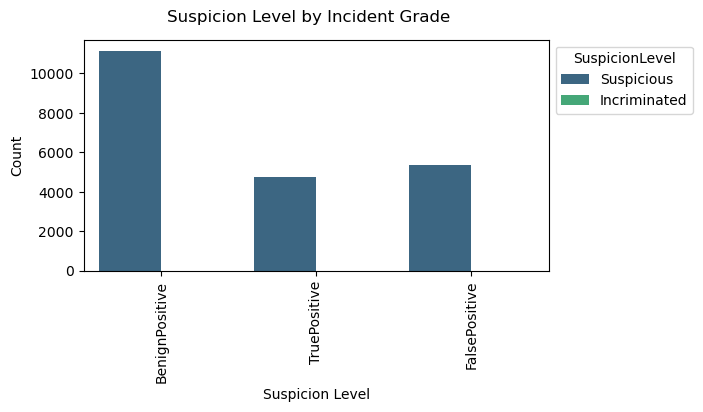

In [34]:
# "suspicion level" refers to the degree of confidence that a detected activity is potentially malicious, 
# often indicated by a "suspicious" verdict within an alert, meaning the system believes there is a high likelihood of a threat 
# but further investigation is needed before taking definitive action; this level can be considered as a 
# middle ground between "clean" (not malicious) and "malicious" (confirmed threat)

# Explore SuspicionLevel feature along with IncidentGrade

# Plot SuspicionLevel with IncidentGrade
plt.figure(figsize=(6, 3))
ax = sns.countplot(data=df_train, x='IncidentGrade', hue='SuspicionLevel', palette='viridis', order=df_train['IncidentGrade'].value_counts().index)
render_plot(ax, heading='Suspicion Level by Incident Grade', xlabel='Suspicion Level', ylabel='Count', plotname='SuspicionLevelByIncidentGrade.png', displaybarlabel=False)



In [35]:
# MitreTechniques

# convert MitreTechniques to extract first technique
df_train['FirstMitreTechnique'] = df_train['MitreTechniques'].str.split(';').str[0]
df_test['FirstMitreTechnique'] = df_test['MitreTechniques'].str.split(';').str[0]

df_train['FirstMitreTechnique'] = df_train['FirstMitreTechnique'].str.split('.').str[0]
df_test['FirstMitreTechnique'] = df_test['FirstMitreTechnique'].str.split('.').str[0]

# add MitreColumns to be dropped later
drop_columns.append('MitreTechniques')

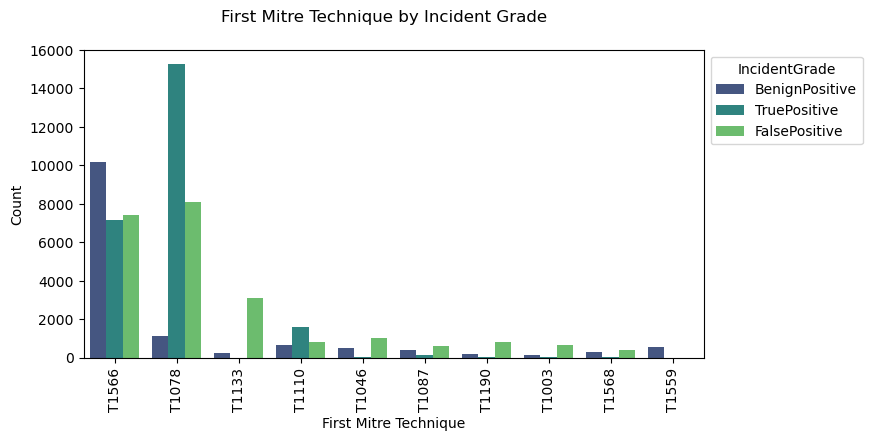

In [36]:
# Plot FirstMitreTechnique with IncidentGrade
plt.figure(figsize=(8, 4))
ax = sns.countplot(data=df_train, x='FirstMitreTechnique', hue='IncidentGrade', order=df_train['FirstMitreTechnique'].value_counts().head(10).index, palette='viridis')
render_plot(ax, heading='First Mitre Technique by Incident Grade', xlabel='First Mitre Technique', ylabel='Count', 
            plotname='FirstMitreTechniqueByIncidentGrade.png', displaybarlabel=False)


#### EDA Numerical Data

In [37]:
# Analyze Geographical Features


# Top 10 countries/state/city by Incident Grade
top_10_country_states = df_train.groupby(['CountryCode', 'State', 'City']).size().reset_index(name='size').sort_values(by='size', ascending=False).head(10)
top_10_country_states

,CountryCode,State,City,size
1340,242,1445,10630,137783
501,1,0,0,1551
698,5,1445,10630,478
0,0,1,1,347
511,2,2,2,306
1,0,1,5,245
767,10,7,4,216
520,2,15,13,214
500,0,1445,10630,202
759,8,10,7,188


This data set represents region #2 in the XDR data that was released by the provider. It is not suprising to see country identified by 242, and city 10630 as the main contributor of all the indicents in this data set. We will remove the CountryCode and State columns

In [38]:
drop_columns.append('State')
drop_columns.append('CountryCode')

In [39]:
columns_fileresource_specifc = ['FileName', 'Sha256', 'FolderPath', 'ResourceIdName', 'ApplicationId', 'ApplicationName']
df_train[columns_fileresource_specifc].corr()

# File name, Sha256, FolderPath appear to be corelated to each other. We will revisit these after our basic models are built

,FileName,Sha256,FolderPath,ResourceIdName,ApplicationId,ApplicationName
FileName,1.000000,0.858549,0.874456,-0.007884,-0.050272,-0.050851
Sha256,0.858549,1.000000,0.734543,-0.006591,-0.042028,-0.042512
FolderPath,0.874456,0.734543,1.000000,-0.007252,-0.046241,-0.046774
ResourceIdName,-0.007884,-0.006591,-0.007252,1.000000,-0.003760,-0.003803
ApplicationId,-0.050272,-0.042028,-0.046241,-0.003760,1.000000,0.988388
ApplicationName,-0.050851,-0.042512,-0.046774,-0.003803,0.988388,1.000000


In [40]:
# Most all of the numerical features in this data set are categorical. We will use models such as 
# RandomForestClassifier, which has the ability to deal with discrete numerical features

### Data Clean Up   

In [41]:
# Drop Columns marked in the EDA section

print('Columns to be dropped: ', drop_columns)  

clean_train = df_train.drop(columns=drop_columns, axis=1).copy()
clean_test = df_test.drop(columns=drop_columns, axis=1).copy()



Columns to be dropped:  ['ResourceType', 'ActionGrouped', 'ActionGranular', 'ThreatFamily', 'EmailClusterId', 'Roles', 'AntispamDirection', 'MitreTechniques', 'State', 'CountryCode']


In [42]:
cat_columns = [col for col in cat_columns if col not in drop_columns]
numerical_columns = [col for col in numerical_columns if col not in drop_columns]

print('Columns that will be used to fit the model: ', cat_columns, numerical_columns)

Columns that will be used to fit the model:  ['Category', 'EntityType', 'EvidenceRole', 'SuspicionLevel', 'LastVerdict'] ['DeviceId', 'Sha256', 'IpAddress', 'Url', 'AccountSid', 'AccountUpn', 'AccountObjectId', 'AccountName', 'DeviceName', 'NetworkMessageId', 'RegistryKey', 'RegistryValueName', 'RegistryValueData', 'ApplicationId', 'ApplicationName', 'OAuthApplicationId', 'FileName', 'FolderPath', 'ResourceIdName', 'OSFamily', 'OSVersion', 'City']


### Train/Test Split

In [43]:
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

X_train_ohe = pd.DataFrame(ohe.fit_transform(clean_train[cat_columns]), columns=ohe.get_feature_names_out())
X_test_ohe = pd.DataFrame(ohe.transform(clean_test[cat_columns]), columns=ohe.get_feature_names_out())

X_train_ohe.index = clean_train.index
X_test_ohe.index = clean_test.index

# X_train_ohe_df = pd.DataFrame(X_train_ohe.toarray(), columns=ohe.get_feature_names_out())
# X_test_ohe_df = pd.DataFrame(X_test_ohe.toarray(), columns=ohe.get_feature_names_out())

# numerical columns - not scaling them, since these values are not continuous and rather represent various entities, devices etc
X_train_data_numerical = clean_train[numerical_columns].fillna(-1)
X_test_data_numerical = clean_test[numerical_columns].fillna(-1)

# # concatenate data frame
X_train = pd.concat([X_train_ohe, X_train_data_numerical], axis=1)
X_test = pd.concat([X_test_ohe, X_test_data_numerical], axis=1)

In [44]:
X_train.sample()

,Category_Collection,Category_CommandAndControl,Category_CredentialAccess,Category_CredentialStealing,Category_DefenseEvasion,Category_Discovery,Category_Execution,Category_Exfiltration,Category_Exploit,Category_Impact,Category_InitialAccess,Category_LateralMovement,Category_Malware,Category_Persistence,Category_PrivilegeEscalation,Category_Ransomware,Category_SuspiciousActivity,Category_UnwantedSoftware,EntityType_AzureResource,EntityType_Blob,EntityType_BlobContainer,EntityType_CloudApplication,EntityType_CloudLogonRequest,EntityType_CloudLogonSession,EntityType_File,EntityType_GenericEntity,EntityType_IoTDevice,EntityType_Ip,EntityType_KubernetesCluster,EntityType_KubernetesNamespace,EntityType_Machine,EntityType_MailCluster,EntityType_MailMessage,EntityType_Mailbox,EntityType_MailboxConfiguration,EntityType_Malware,EntityType_OAuthApplication,EntityType_Process,EntityType_RegistryKey,EntityType_RegistryValue,EntityType_SecurityGroup,EntityType_Url,EntityType_User,EvidenceRole_Impacted,EvidenceRole_Related,SuspicionLevel_Incriminated,SuspicionLevel_Suspicious,SuspicionLevel_nan,LastVerdict_DomainPII_50d8b4a941c26b89482c94ab324b5a274f9ced66,LastVerdict_Malicious,LastVerdict_NoThreatsFound,LastVerdict_Suspicious,LastVerdict_nan,DeviceId,Sha256,IpAddress,Url,AccountSid,AccountUpn,AccountObjectId,AccountName,DeviceName,NetworkMessageId,RegistryKey,RegistryValueName,RegistryValueData,ApplicationId,ApplicationName,OAuthApplicationId,FileName,FolderPath,ResourceIdName,OSFamily,OSVersion,City
58842,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,98799,138268,360606,160396,2945,3922,2955,3105,153085,529644,1631,635,860,2251,3421,881,289573,117668,3586,5,66,10630


In [45]:
y_train = df_train['IncidentGrade']
y_test = df_test['IncidentGrade']

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((150000, 75), (150000, 75), (150000,), (150000,))

### Basic Classifiers

In [46]:
# helper functions to run and evaluate models and draw the ROC curve

def run_and_eval_model(model, model_name, X_train, X_test, y_train, y_test):
    
    print(f"Fitting {model_name}...")
    start_time = time.time()

    # fit the selected model 
    model.fit(X_train, y_train.values.ravel())
    
    fit_time = round(time.time() - start_time, 2)
    
    start_time = time.time()
    
    train_score, test_accuracy, precision, recall, f1 = eval_model(model, model_name, X_train, X_test, y_train, y_test)
    
    eval_time = round(time.time() - start_time, 2)
    
    print(f"{model_name} with train accuracy score {train_score:.3f}, took {time.time()-start_time:.3f} seconds")
    
    return {'model': model_name, 
            'train accuracy': train_score, 
            'test accuracy': test_accuracy,
            'precision': precision, 
            'recall': recall,
            'f1': f1,
            'fit time': fit_time,
            'eval time': eval_time}
    
def eval_model(model, model_name, X_train, X_test, y_train, y_test, show_cm=True):
    
    print(f"Evaluating {model_name}...")
    
    train_score = cross_val_score(model, X_train, y_train.values.ravel(), cv=5, scoring='accuracy').mean()
    y_pred = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred, average='macro', zero_division=np.nan)
    precision = precision_score(y_test, y_pred, average='macro', zero_division=np.nan)
    f1 = f1_score(y_test, y_pred, average='macro', zero_division=np.nan)
    
    # print classification report
    print(classification_report(y_test, y_pred))
    
    # print confusion matrix
    if show_cm:
        _classes = model.classes_
        cm = confusion_matrix(y_test, y_pred, labels = _classes)
        disp = ConfusionMatrixDisplay(confusion_matrix = cm,display_labels = _classes)
        # show the plot    
        plt.figure(figsize=(3, 3))
        disp.plot()
        plt.show()
    
    return train_score, test_accuracy, precision, recall, f1

    
def draw_roc_curves(X_test, y_test, model, model_name):
    
    # Create ROC curves for each of the classes

    # Get the predicted probabilities
    y_score = model.predict_proba(X_test)

    # Binarize the output labels for ROC curve
    y_test_bin = pd.get_dummies(y_test)

    # Plot ROC curve for each class
    plt.figure(figsize=(10, 8))
    for i, class_name in enumerate(y_test_bin.columns):
        fpr, tpr, _ = roc_curve(y_test_bin[class_name], y_score[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f}) for class {class_name}')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {model_name}')
    plt.legend(loc="lower right")
    plt.show()
    
def get_feature_importance(model):
    
    feature_names = model.feature_names_in_

    # clean the feature names
    clean_feature_names = [name.split('__')[-1] for name in feature_names]

    # feature important
    return pd.DataFrame({'feature': clean_feature_names, 'importance': model.feature_importances_})



Fitting Decision Trees...
Evaluating Decision Trees...
                precision    recall  f1-score   support

BenignPositive       0.65      0.67      0.66     50000
 FalsePositive       0.64      0.63      0.63     50000
  TruePositive       0.71      0.69      0.70     50000

      accuracy                           0.66    150000
     macro avg       0.66      0.66      0.66    150000
  weighted avg       0.66      0.66      0.66    150000



<Figure size 300x300 with 0 Axes>

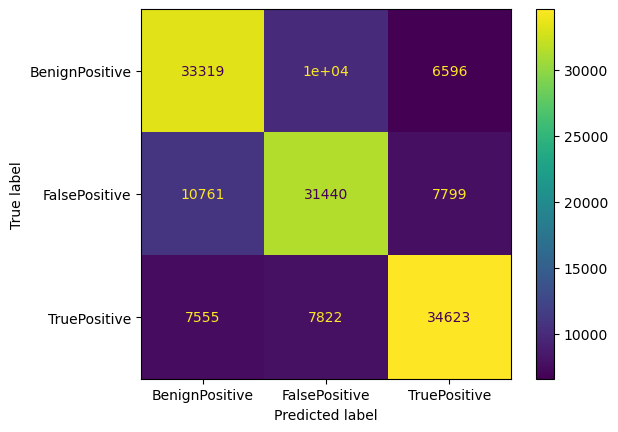

Decision Trees with train accuracy score 0.660, took 8.668 seconds


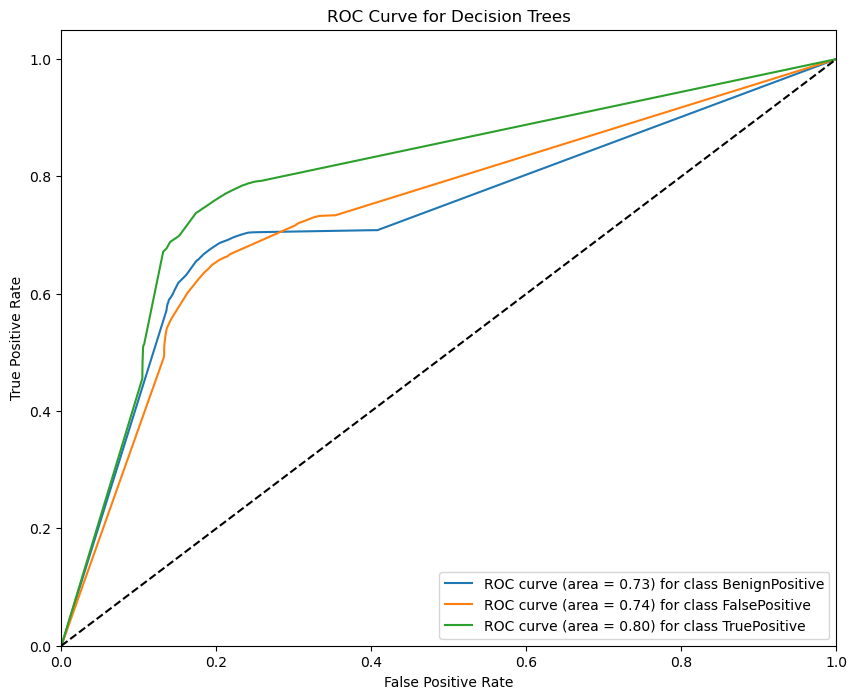

Fitting Random Forest...
Evaluating Random Forest...
                precision    recall  f1-score   support

BenignPositive       0.65      0.70      0.67     50000
 FalsePositive       0.65      0.63      0.64     50000
  TruePositive       0.72      0.70      0.71     50000

      accuracy                           0.67    150000
     macro avg       0.68      0.67      0.67    150000
  weighted avg       0.68      0.67      0.67    150000



<Figure size 300x300 with 0 Axes>

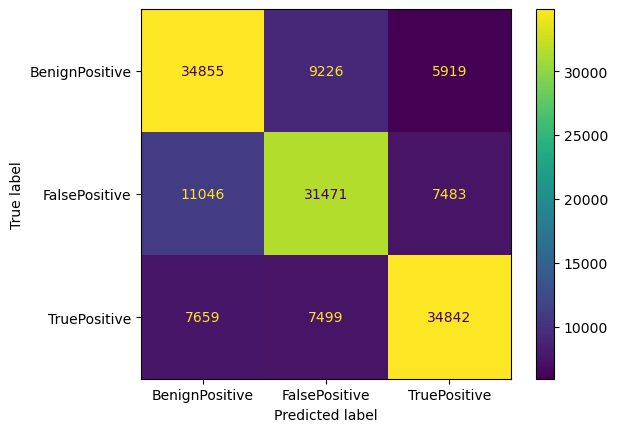

Random Forest with train accuracy score 0.673, took 74.101 seconds


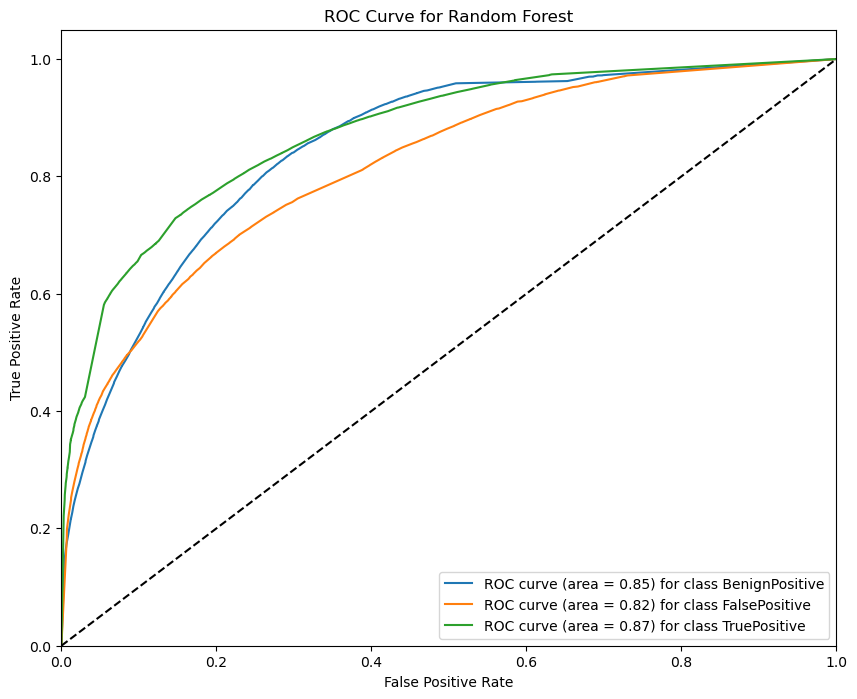

Fitting Gradient Boosting...
Evaluating Gradient Boosting...
                precision    recall  f1-score   support

BenignPositive       0.57      0.72      0.64     50000
 FalsePositive       0.57      0.55      0.56     50000
  TruePositive       0.75      0.59      0.66     50000

      accuracy                           0.62    150000
     macro avg       0.63      0.62      0.62    150000
  weighted avg       0.63      0.62      0.62    150000



<Figure size 300x300 with 0 Axes>

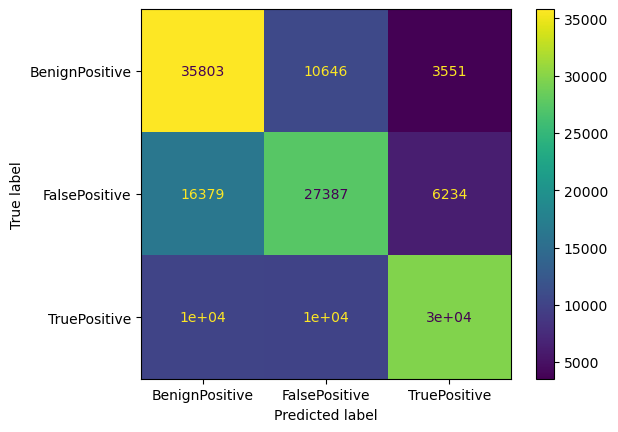

Gradient Boosting with train accuracy score 0.600, took 213.744 seconds


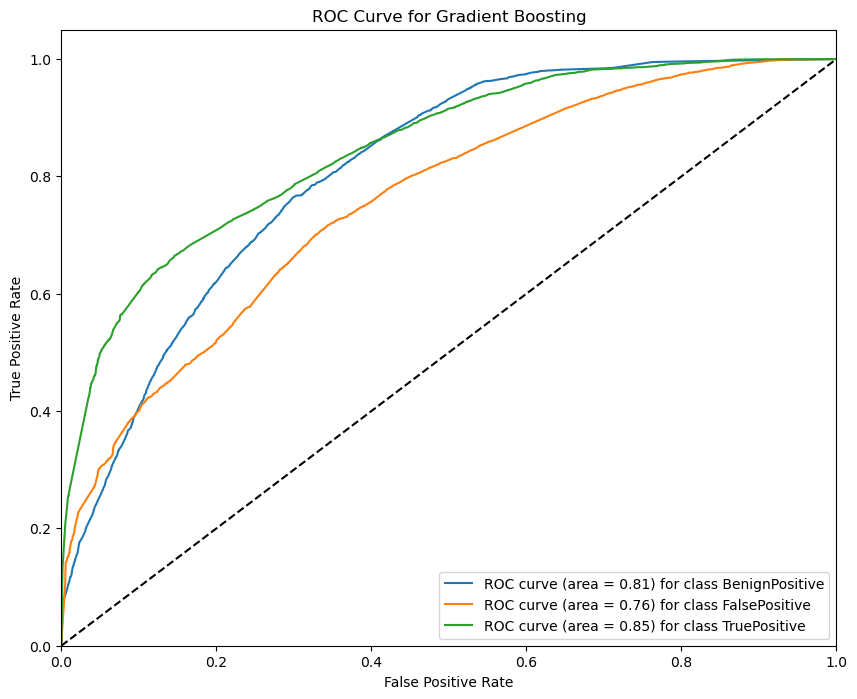

Fitting KNN...
Evaluating KNN...
                precision    recall  f1-score   support

BenignPositive       0.44      0.70      0.54     50000
 FalsePositive       0.59      0.48      0.53     50000
  TruePositive       0.70      0.41      0.52     50000

      accuracy                           0.53    150000
     macro avg       0.58      0.53      0.53    150000
  weighted avg       0.58      0.53      0.53    150000



<Figure size 300x300 with 0 Axes>

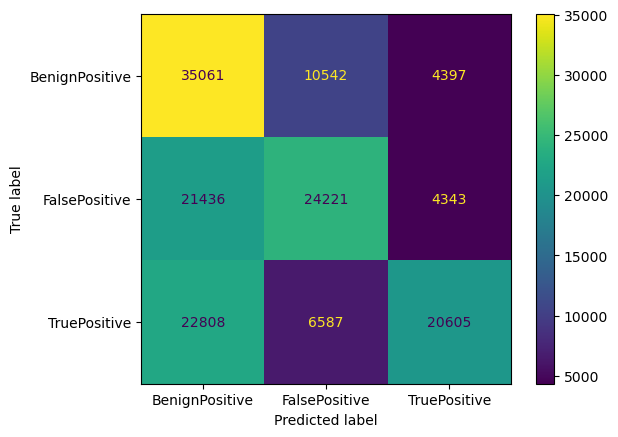

KNN with train accuracy score 0.531, took 49.185 seconds


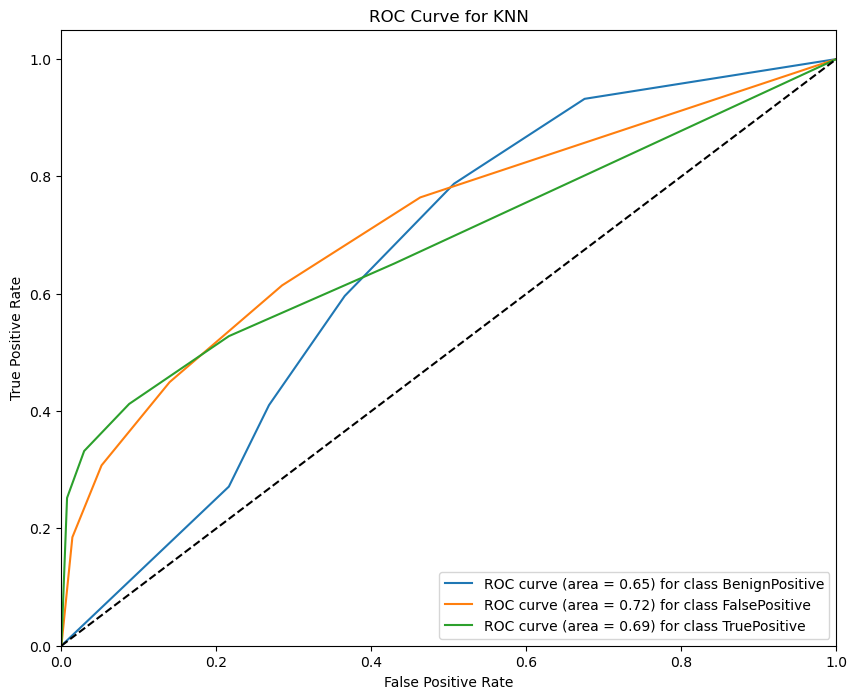

,model,train accuracy,test accuracy,precision,recall,f1,fit time,eval time
0,Decision Trees,0.659633,0.662547,0.662911,0.662547,0.662640,0.94,8.67
1,Random Forest,0.673400,0.674453,0.675316,0.674453,0.674472,17.14,74.10
2,Gradient Boosting,0.599860,0.619440,0.631850,0.619440,0.619887,52.41,213.74
3,KNN,0.530747,0.532580,0.576674,0.532580,0.530656,0.19,49.19


In [47]:
# List of classification models to try with default hyperparameters

classifiers = {
    'Decision Trees': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    #'Logistic Regression': LogisticRegression(max_iter=50000),         # LR took too long and the MacroF1 were not as good as RF/DT
    #'SVM': SVC(decision_function_shape='ovr', probability=True),       # SVM took too long and the MacroF1 were not as good as RF/DT
    'Gradient Boosting': GradientBoostingClassifier(),
    'KNN': KNeighborsClassifier()
}

models_evaluated = pd.DataFrame()

for model_name, classifer in classifiers.items():
    dict = run_and_eval_model(classifer, model_name, X_train, X_test, y_train, y_test)
    models_evaluated = pd.concat([models_evaluated, pd.DataFrame([dict])], ignore_index=True)
    draw_roc_curves(X_test, y_test, classifer, model_name)
    
models_evaluated


### Decision Tree

That is quite a deep tree and may likely overfit unseen data

In [48]:
# setup a GridSearchCV for the Decision Tree model

params = {'dt__min_impurity_decrease': [0.01, 0.1, 1.0],
          'dt__max_depth': [10, 20, 30],
          'dt__min_samples_split': [0.1, 0.05]}

dt_pipe = Pipeline([('dt', DecisionTreeClassifier(random_state = 42))])

dt_grid = GridSearchCV(estimator=dt_pipe, param_grid=params, n_jobs=10, verbose=1)

In [49]:
dt_grid.fit(X_train, y_train)

dt_grid.best_params_

Fitting 5 folds for each of 18 candidates, totalling 90 fits


{'dt__max_depth': 10,
 'dt__min_impurity_decrease': 0.01,
 'dt__min_samples_split': 0.1}

Evaluating Decision Tree...
                precision    recall  f1-score   support

BenignPositive       0.48      0.74      0.58     50000
 FalsePositive       0.45      0.40      0.43     50000
  TruePositive       0.80      0.45      0.57     50000

      accuracy                           0.53    150000
     macro avg       0.58      0.53      0.53    150000
  weighted avg       0.58      0.53      0.53    150000



<Figure size 300x300 with 0 Axes>

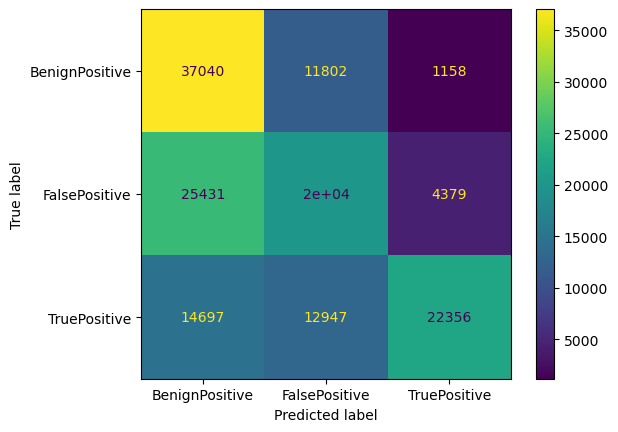

In [50]:
scores = eval_model(dt_grid.best_estimator_, 'Decision Tree', X_train, X_test, y_train, y_test)

In [51]:
# export the tree

dt = dt_grid.best_estimator_.named_steps['dt']
feature_importance = get_feature_importance(dt)
clean_feature_names = feature_importance['feature'].tolist()

depth = export_text(dt, feature_names=clean_feature_names)
export_text(dt, feature_names=clean_feature_names, show_weights=True)

print(depth)

tree_depth = dt.tree_.max_depth  
print("Depth of the fitted decision tree:", tree_depth) 

|--- Category_InitialAccess <= 0.50
|   |--- class: BenignPositive
|--- Category_InitialAccess >  0.50
|   |--- IpAddress <= 5256.50
|   |   |--- class: TruePositive
|   |--- IpAddress >  5256.50
|   |   |--- DeviceName <= 3808.50
|   |   |   |--- class: FalsePositive
|   |   |--- DeviceName >  3808.50
|   |   |   |--- EntityType_CloudLogonRequest <= 0.50
|   |   |   |   |--- AccountObjectId <= 10667.50
|   |   |   |   |   |--- class: TruePositive
|   |   |   |   |--- AccountObjectId >  10667.50
|   |   |   |   |   |--- class: FalsePositive
|   |   |   |--- EntityType_CloudLogonRequest >  0.50
|   |   |   |   |--- class: TruePositive

Depth of the fitted decision tree: 5


### Random Forest

In [52]:
rfc = RandomForestClassifier(random_state=42, n_jobs=-1)

rf_grid_params = {'n_estimators': [50, 100, 150, 300],
          'min_samples_split': [0.1, 0.01, 0.001],
          'oob_score': [True, False],
          'max_features': ['sqrt', 'log2'],
          }

rf_grid = GridSearchCV(estimator=rfc, param_grid=rf_grid_params, n_jobs=5, verbose=1)

#### Random Forest w/GridSearch

In [53]:
rf_grid.fit(X_train, y_train)
y_pred = rf_grid.predict(X_test)
rf_grid.best_params_

Fitting 5 folds for each of 48 candidates, totalling 240 fits


{'max_features': 'sqrt',
 'min_samples_split': 0.001,
 'n_estimators': 50,
 'oob_score': True}

In [54]:
rf_grid.best_estimator_

RandomForestClassifier(min_samples_split=0.001, n_estimators=50, n_jobs=-1,
                       oob_score=True, random_state=42)

Evaluating Random Forest...
                precision    recall  f1-score   support

BenignPositive       0.60      0.76      0.67     50000
 FalsePositive       0.64      0.56      0.60     50000
  TruePositive       0.74      0.65      0.69     50000

      accuracy                           0.66    150000
     macro avg       0.66      0.66      0.65    150000
  weighted avg       0.66      0.66      0.65    150000



<Figure size 300x300 with 0 Axes>

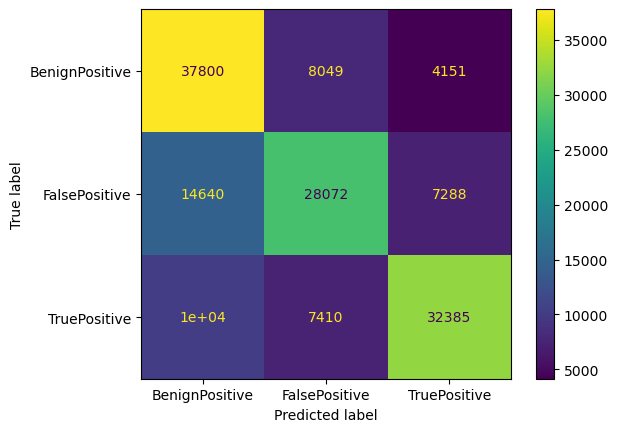

In [55]:
scores = eval_model(rf_grid.best_estimator_, 'Random Forest', X_train, X_test, y_train, y_test, True)

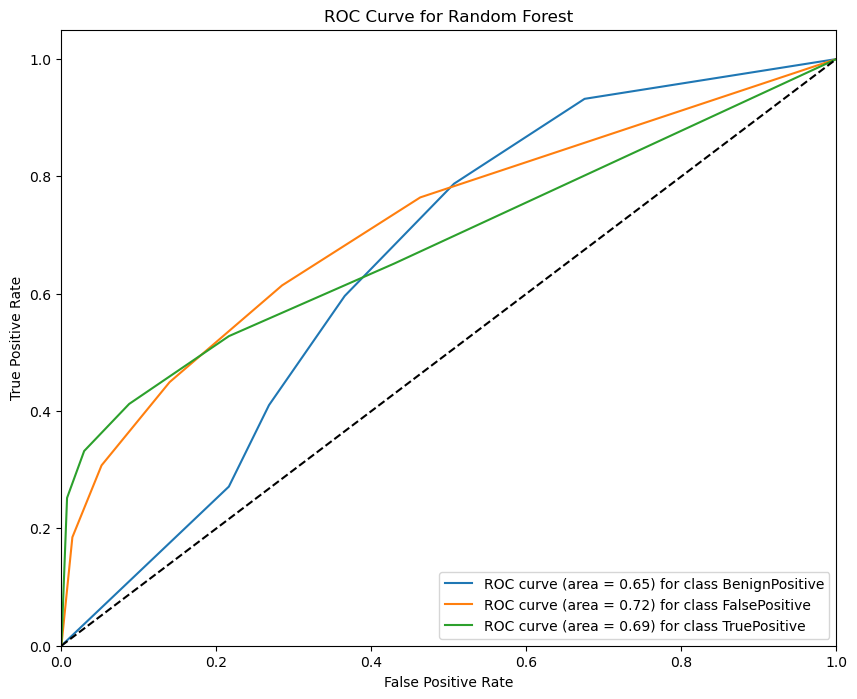

In [56]:
draw_roc_curves(X_test, y_test, classifer, "Random Forest")

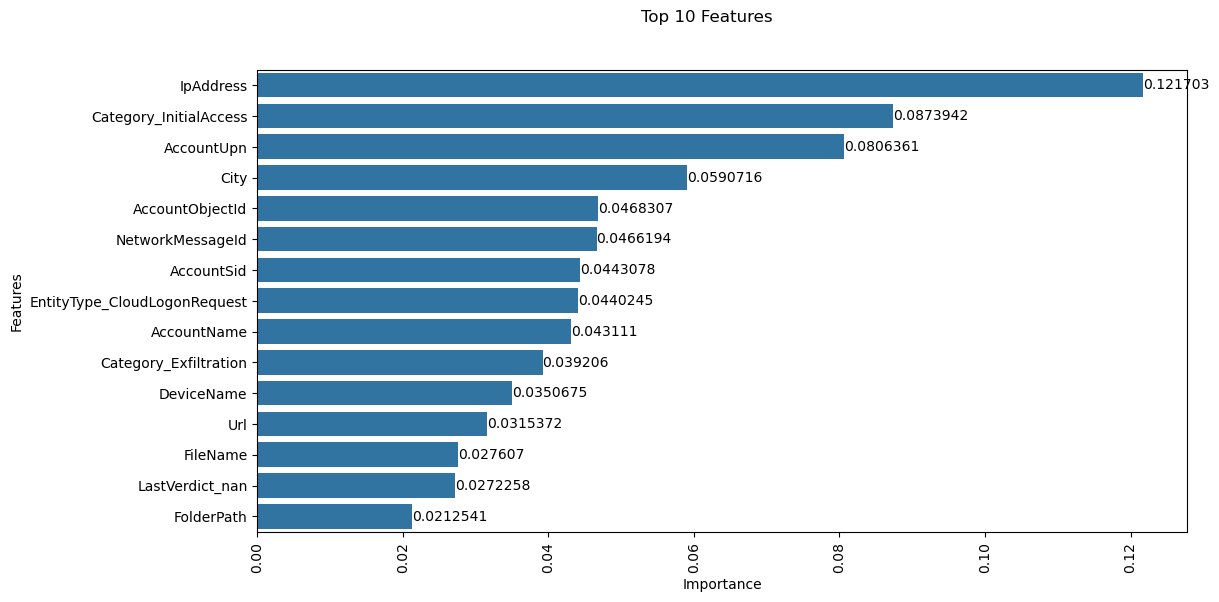

In [57]:
feature_importance = get_feature_importance(rf_grid.best_estimator_)

plt.figure(figsize=(12, 6))
ax = sns.barplot(x='importance', y='feature', data=feature_importance.sort_values(by='importance', ascending=False).head(15))
render_plot(ax, heading='Top 10 Features', xlabel='Importance', ylabel='Features', plotname='Top10Features.png', displaybarlabel=True)


#### RandomForest with RandomizedSearchCV

In [58]:
from sklearn.model_selection import RandomizedSearchCV

rf_random_grid = RandomizedSearchCV(estimator=rfc, param_distributions=rf_grid_params, verbose=2, random_state=42, n_jobs=5)


In [59]:
rf_random_grid.fit(X_train, y_train)
rf_random_grid.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END max_features=log2, min_samples_split=0.1, n_estimators=100, oob_score=False; total time=   3.5s
[CV] END max_features=log2, min_samples_split=0.1, n_estimators=100, oob_score=False; total time=   3.5s
[CV] END max_features=log2, min_samples_split=0.1, n_estimators=100, oob_score=False; total time=   3.4s
[CV] END max_features=log2, min_samples_split=0.1, n_estimators=100, oob_score=False; total time=   3.5s
[CV] END max_features=log2, min_samples_split=0.1, n_estimators=100, oob_score=False; total time=   3.5s
[CV] END max_features=log2, min_samples_split=0.001, n_estimators=50, oob_score=True; total time=   6.1s
[CV] END max_features=log2, min_samples_split=0.001, n_estimators=50, oob_score=True; total time=   6.2s
[CV] END max_features=log2, min_samples_split=0.001, n_estimators=50, oob_score=True; total time=   6.2s
[CV] END max_features=log2, min_samples_split=0.001, n_estimators=50, oob_score=True; total time=  

{'oob_score': False,
 'n_estimators': 100,
 'min_samples_split': 0.001,
 'max_features': 'sqrt'}

In [60]:
eval_model(rf_random_grid.best_estimator_, 'Random Forest with Random Search', X_train, X_test, y_train, y_test, False)

Evaluating Random Forest with Random Search...
                precision    recall  f1-score   support

BenignPositive       0.60      0.76      0.67     50000
 FalsePositive       0.64      0.57      0.60     50000
  TruePositive       0.74      0.65      0.69     50000

      accuracy                           0.66    150000
     macro avg       0.66      0.66      0.65    150000
  weighted avg       0.66      0.66      0.65    150000



(0.6492733333333334,
 0.6558466666666667,
 0.6633567135968964,
 0.6558466666666666,
 0.6548485793266441)

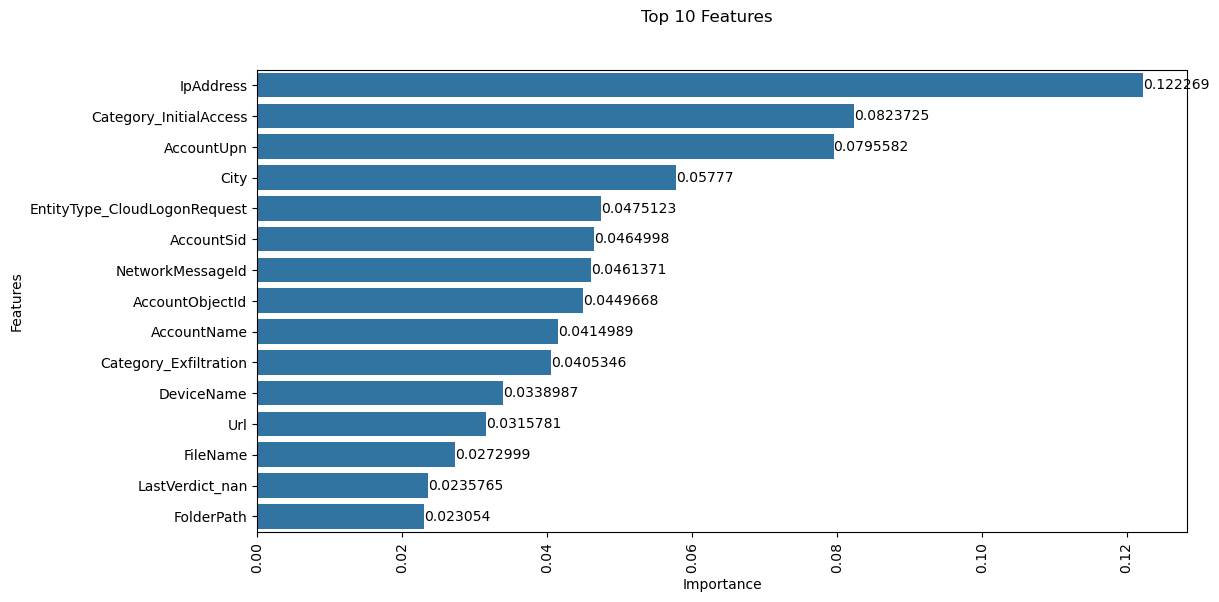

In [61]:
feature_importance = get_feature_importance(rf_random_grid.best_estimator_)

plt.figure(figsize=(12, 6))
ax = sns.barplot(x='importance', y='feature', data=feature_importance.sort_values(by='importance', ascending=False).head(15))
render_plot(ax, heading='Top 10 Features', xlabel='Importance', ylabel='Features')


#### Randomized search with top features

In [62]:
# Evaluate if we rebuild the model with only the features whose importance is > 0.01

top_features = feature_importance[feature_importance.importance > 0.01].feature.values

X_train_imp = X_train[top_features]
X_test_imp = X_test[top_features]

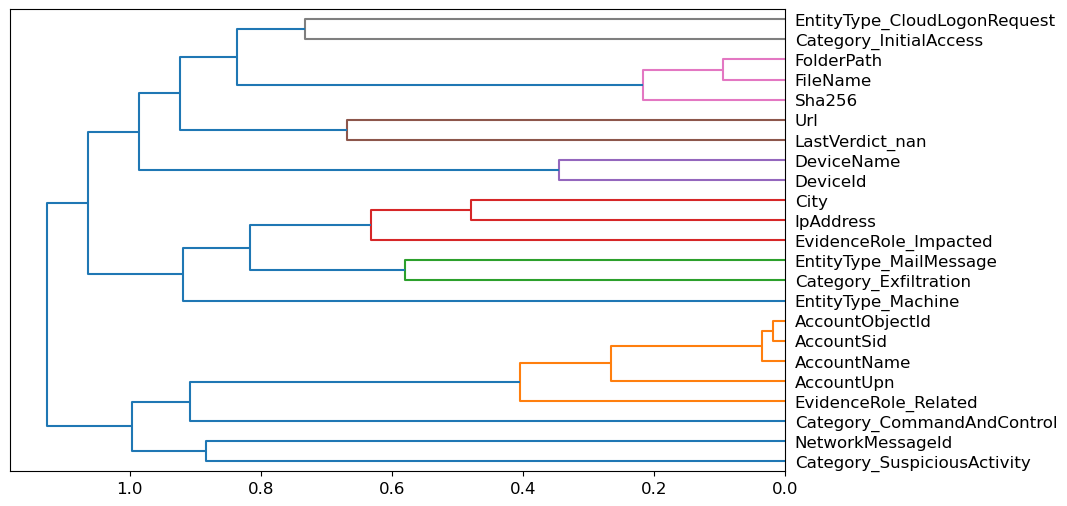

In [63]:
# This library is used to visualize the clusters of features and their corelation with the each other
import fastbook
fastbook.cluster_columns(X_train_imp)

In [64]:
# Build a model with the top features only

rf_random_grid_top_features = RandomizedSearchCV(estimator=rfc, param_distributions=rf_grid_params, verbose=1, random_state=42, n_jobs=5)
rf_random_grid_top_features.fit(X_train_imp, y_train)
rf_random_grid_top_features.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


{'oob_score': False,
 'n_estimators': 100,
 'min_samples_split': 0.001,
 'max_features': 'log2'}

In [65]:
eval_model(rf_random_grid_top_features.best_estimator_, 'Random Forest with Random Search with top features only', 
           X_train_imp, X_test_imp, y_train, y_test, False)

Evaluating Random Forest with Random Search with top features only...
                precision    recall  f1-score   support

BenignPositive       0.59      0.75      0.66     50000
 FalsePositive       0.65      0.55      0.59     50000
  TruePositive       0.73      0.65      0.68     50000

      accuracy                           0.65    150000
     macro avg       0.66      0.65      0.65    150000
  weighted avg       0.66      0.65      0.65    150000



(0.6424133333333334, 0.64812, 0.6554842794129477, 0.64812, 0.6466662369078416)

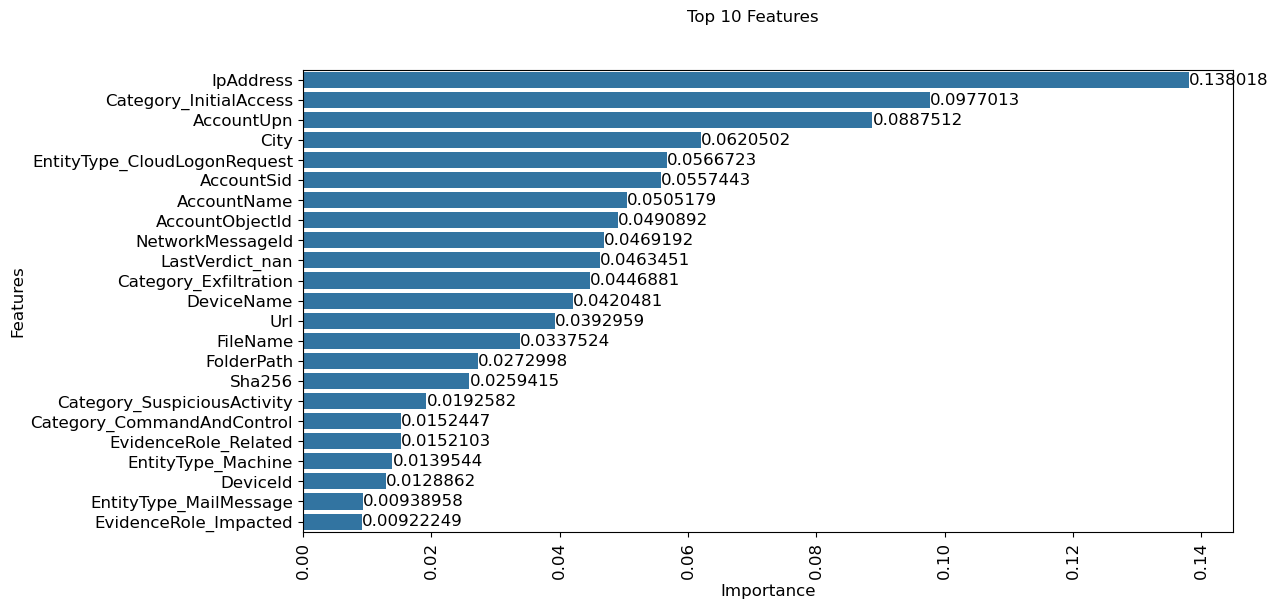

In [66]:
feature_importance = get_feature_importance(rf_random_grid_top_features.best_estimator_)

plt.figure(figsize=(12, 6))
ax = sns.barplot(x='importance', y='feature', data=feature_importance.sort_values(by='importance', ascending=False))
render_plot(ax, heading='Top 10 Features', xlabel='Importance', ylabel='Features')

### Next Steps

#### What can we do further improve the Recall and Precision Scores

- Further feature engineering?
- hyper parameter turning
- Class imbalance
- Focus on other models, beyond RF

- WIP ...

### Extra exploration: Visualize the impact of each feature on the final prediction

In [67]:
# find a couple of TruePositive alerts
tp_sample_indices = y_train[y_train == 'TruePositive'].sample(2, random_state=23).index.values
tp_sample_indices

array([344181, 246819])

In [68]:
# use these indexes to find the corresponding alerts in the training data set
X_train_imp.loc[tp_sample_indices]

,Category_CommandAndControl,Category_Exfiltration,Category_InitialAccess,Category_SuspiciousActivity,EntityType_CloudLogonRequest,EntityType_Machine,EntityType_MailMessage,EvidenceRole_Impacted,EvidenceRole_Related,LastVerdict_nan,DeviceId,Sha256,IpAddress,Url,AccountSid,AccountUpn,AccountObjectId,AccountName,DeviceName,NetworkMessageId,FileName,FolderPath,City
344181,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,98799,138268,3725,160396,441377,673934,425863,453297,153085,529644,289573,117668,10630
246819,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,98799,1639,360606,160396,441377,673934,425863,453297,153085,529644,39,3,10630


['TruePositive']
The model prediction for row index 344181 is [[0.34563431 0.07359429 0.5807714 ]], the the actual value is TruePositive
['BenignPositive']


/opt/anaconda3/envs/BerkeleyAIML/lib/python3.12/site-packages/waterfall_chart.py:141: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y = y_height[loop] + row['amount']
/opt/anaconda3/envs/BerkeleyAIML/lib/python3.12/site-packages/waterfall_chart.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y = y_height[loop]


The model prediction for row index 246819 is [[0.54968764 0.31244862 0.13786374]], the the actual value is TruePositive


/opt/anaconda3/envs/BerkeleyAIML/lib/python3.12/site-packages/waterfall_chart.py:141: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y = y_height[loop] + row['amount']
/opt/anaconda3/envs/BerkeleyAIML/lib/python3.12/site-packages/waterfall_chart.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y = y_height[loop]


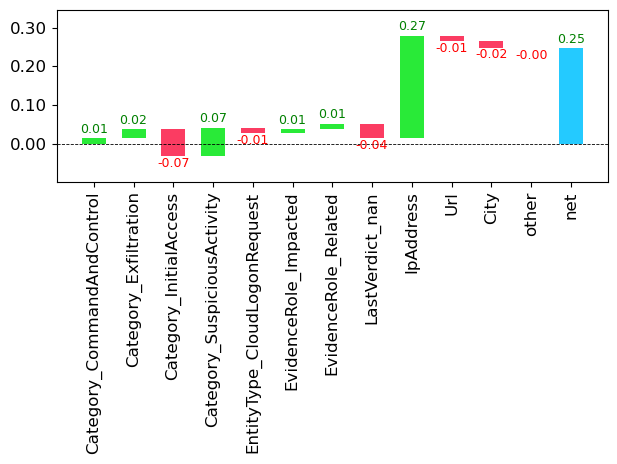

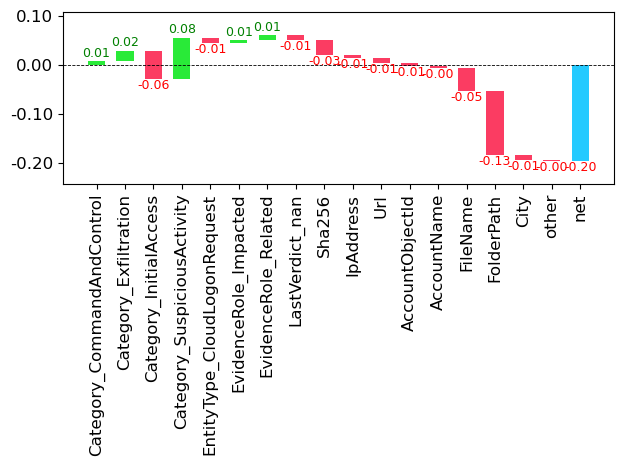

In [69]:
# Waterfall library to visualize the contribution of each feature to the prediction

from treeinterpreter import treeinterpreter
from waterfall_chart import plot as waterfall


for index in tp_sample_indices:
    
    #print(index)
    row = X_train_imp[X_train_imp.index == index]
    
    print(rf_random_grid_top_features.best_estimator_.predict(row))
    
    prediction, bias, contributions = treeinterpreter.predict(rf_random_grid_top_features.best_estimator_, row.values)
    
    print(f'The model prediction for row index {index} is {prediction}, the the actual value is {y_train.loc[index]}')
    
    # contributons is a 2D array, where columns represent BP (col = 0), FP (col = 1 ) or TP (col=2), and rows represent the contribution of that 
    # feature to the prediction for that class
    waterfall(X_train_imp.columns, contributions[0,:,2], threshold=0.03, 
               rotation_value=90, formatting='{:,.2f}');
